In [2]:
## Data manipulation
import numpy as np
import pandas as pd
from scipy import stats

## Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline
plt.style.use('seaborn')


## Modelling
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge,ElasticNet, SGDRegressor, LogisticRegression
from sklearn.model_selection import train_test_split
from scipy import sparse
from scipy.stats import norm, skew

from sklearn.decomposition import TruncatedSVD, PCA, LatentDirichletAllocation, NMF
from sklearn.manifold import TSNE

import copy

## Others
import os
import time
import warnings
import gc
import os
import pickle
from six.moves import urllib
import warnings
warnings.filterwarnings('ignore')


# Load data

In [3]:
# Win
train_df = pd.read_csv('/Users/chloe.song/Documents/Projects/DS191/Kaggle-Santander Customer Transaction Prediction/train.csv')
test_df = pd.read_csv('/Users/chloe.song/Documents/Projects/DS191/Kaggle-Santander Customer Transaction Prediction/test.csv')

full_df = pd.concat((train_df, test_df))

print("Train data:", train_df.info())
print("Test data:", test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB
Train data: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB
Test data: None


## Define variables that are useful for later use

In [4]:
# Numerical features
num_vars = []
# Categorical features
cat_vars = []
for var, dtype in full_df.dtypes.items():
    if 'float' in str(dtype) or 'int' in str(dtype):
        num_vars.append(var)
    if 'object' in str(dtype):
        cat_vars.append(var)
        
id_var = 'ID_code'
cat_vars.remove(id_var)
target_var = 'target'
num_vars.remove(target_var)

print ("There are %d numerical features: %s" 
       % (len(num_vars), num_vars))

print ("There are %d numerical features: %s" 
       % (len(cat_vars), cat_vars))

There are 200 numerical features: ['var_0', 'var_1', 'var_10', 'var_100', 'var_101', 'var_102', 'var_103', 'var_104', 'var_105', 'var_106', 'var_107', 'var_108', 'var_109', 'var_11', 'var_110', 'var_111', 'var_112', 'var_113', 'var_114', 'var_115', 'var_116', 'var_117', 'var_118', 'var_119', 'var_12', 'var_120', 'var_121', 'var_122', 'var_123', 'var_124', 'var_125', 'var_126', 'var_127', 'var_128', 'var_129', 'var_13', 'var_130', 'var_131', 'var_132', 'var_133', 'var_134', 'var_135', 'var_136', 'var_137', 'var_138', 'var_139', 'var_14', 'var_140', 'var_141', 'var_142', 'var_143', 'var_144', 'var_145', 'var_146', 'var_147', 'var_148', 'var_149', 'var_15', 'var_150', 'var_151', 'var_152', 'var_153', 'var_154', 'var_155', 'var_156', 'var_157', 'var_158', 'var_159', 'var_16', 'var_160', 'var_161', 'var_162', 'var_163', 'var_164', 'var_165', 'var_166', 'var_167', 'var_168', 'var_169', 'var_17', 'var_170', 'var_171', 'var_172', 'var_173', 'var_174', 'var_175', 'var_176', 'var_177', 'var_178'

# EDA

## Description of datasets:

In [5]:
train_df.describe()

target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679914      -1.627622      10.715192   
std         0.300653       3.040051       4.050044       2.640894   
min         0.000000       0.408400     -15.043400       2.117100   
25%         0.000000       8.453850      -4.740025       8.722475   
50%         0.000000      10.524750      -1.608050      10.580000   
75%         0.000000      12.758200       1.358625      12.516700   
max         1.000000      20.315000      10.376800      19.353000   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796529      11.078333      -5.065317       5.408949   
std         2.043319       1.623150       7.863267       0.866607   
min        -0.040200       5.074800     -32.562600       2.347300   
25%         5.254075       9.883175     -11.200350       4.767700   
50%         6.825000      11.108250      -4.833150       5.385100   
75%         8.324100      12.261125       0.924800       6.003000   
max        13.188300      16.671400      17.251600       8.447700   

               var_7          var_8      ...              var_190  \
count  200000.000000  200000.000000      ...        200000.000000   
mean       16.545850       0.284162      ...             3.234440   
std         3.418076       3.332634      ...             4.559922   
min         5.349700     -10.505500      ...           -14.093300   
25%        13.943800      -2.317800      ...            -0.058825   
50%        16.456800       0.393700      ...             3.203600   
75%        19.102900       2.937900      ...             6.406200   
max        27.691800      10.151300      ...            18.440900   

             var_191        var_192        var_193        var_194  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        7.438408       1.927839       3.331774      17.993784   
std         3.023272       1.478423       3.992030       3.135162   
min        -2.691700      -3.814500     -11.783400       8.694400   
25%         5.157400       0.889775       0.584600      15.629800   
50%         7.347750       1.901300       3.396350      17.957950   
75%         9.512525       2.949500       6.205800      20.396525   
max        16.716500       8.402400      18.281800      27.928800   

             var_195        var_196        var_197        var_198  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       -0.142088       2.303335       8.908158      15.870720   
std         1.429372       5.454369       0.921625       3.010945   
min        -5.261000     -14.209600       5.960600       6.299300   
25%        -1.170700      -1.946925       8.252800      13.829700   
50%        -0.172700       2.408900       8.888200      15.934050   
75%         0.829600       6.556725       9.593300      18.064725   
max         4.272900      18.321500      12.000400      26.079100   

             var_199  
count  200000.000000  
mean       -3.326537  
std        10.438015  
min       -38.852800  
25%       -11.208475  
50%        -2.819550  
75%         4.836800  
max        28.500700  

[8 rows x 201 columns]

In [6]:
test_df.describe()

var_0          var_1          var_2          var_3  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       10.658737      -1.624244      10.707452       6.788214   
std         3.036716       4.040509       2.633888       2.052724   
min         0.188700     -15.043400       2.355200      -0.022400   
25%         8.442975      -4.700125       8.735600       5.230500   
50%        10.513800      -1.590500      10.560700       6.822350   
75%        12.739600       1.343400      12.495025       8.327600   
max        22.323400       9.385100      18.714100      13.142000   

               var_4          var_5          var_6          var_7  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       11.076399      -5.050558       5.415164      16.529143   
std         1.616456       7.869293       0.864686       3.424482   
min         5.484400     -27.767000       2.216400       5.713700   
25%         9.891075     -11.201400       4.772600      13.933900   
50%        11.099750      -4.834100       5.391600      16.422700   
75%        12.253400       0.942575       6.005800      19.094550   
max        16.037100      17.253700       8.302500      28.292800   

               var_8          var_9      ...              var_190  \
count  200000.000000  200000.000000      ...        200000.000000   
mean        0.277135       7.569407      ...             3.189766   
std         3.333375       1.231865      ...             4.551239   
min        -9.956000       4.243300      ...           -14.093300   
25%        -2.303900       6.623800      ...            -0.095000   
50%         0.372000       7.632000      ...             3.162400   
75%         2.930025       8.584825      ...             6.336475   
max         9.665500      11.003600      ...            20.359000   

             var_191        var_192        var_193        var_194  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        7.458269       1.925944       3.322016      17.996967   
std         3.025189       1.479966       3.995599       3.140652   
min        -2.407000      -3.340900     -11.413100       9.382800   
25%         5.166500       0.882975       0.587600      15.634775   
50%         7.379000       1.892600       3.428500      17.977600   
75%         9.531100       2.956000       6.174200      20.391725   
max        16.716500       8.005000      17.632600      27.947800   

             var_195        var_196        var_197        var_198  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       -0.133657       2.290899       8.912428      15.869184   
std         1.429678       5.446346       0.920904       3.008717   
min        -4.911900     -13.944200       6.169600       6.584000   
25%        -1.160700      -1.948600       8.260075      13.847275   
50%        -0.162000       2.403600       8.892800      15.943400   
75%         0.837900       6.519800       9.595900      18.045200   
max         4.545400      15.920700      12.275800      26.538400   

             var_199  
count  200000.000000  
mean       -3.246342  
std        10.398589  
min       -39.457800  
25%       -11.124000  
50%        -2.725950  
75%         4.935400  
max        27.907400  

[8 rows x 200 columns]

## Target distribution

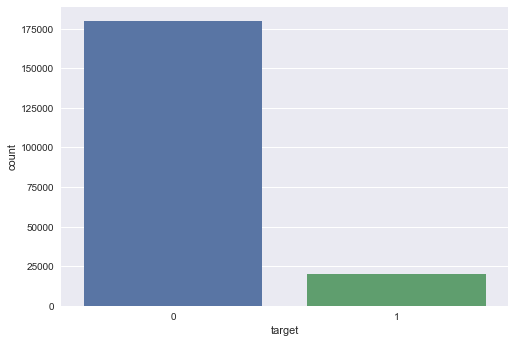

In [7]:
sns.countplot(train_df['target'])

# imbalanced，0是1的好几十倍

## Missing values

In [8]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)  # 每个var里空值数量/每个var里所有值数量
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [9]:
missing_data(train_df)

ID_code target    var_0    var_1    var_2    var_3    var_4    var_5  \
Total         0      0        0        0        0        0        0        0   
Percent       0      0        0        0        0        0        0        0   
Types    object  int64  float64  float64  float64  float64  float64  float64   

           var_6    var_7   ...     var_190  var_191  var_192  var_193  \
Total          0        0   ...           0        0        0        0   
Percent        0        0   ...           0        0        0        0   
Types    float64  float64   ...     float64  float64  float64  float64   

         var_194  var_195  var_196  var_197  var_198  var_199  
Total          0        0        0        0        0        0  
Percent        0        0        0        0        0        0  
Types    float64  float64  float64  float64  float64  float64  

[3 rows x 202 columns]

In [10]:
missing_data(test_df)

ID_code    var_0    var_1    var_2    var_3    var_4    var_5  \
Total         0        0        0        0        0        0        0   
Percent       0        0        0        0        0        0        0   
Types    object  float64  float64  float64  float64  float64  float64   

           var_6    var_7    var_8   ...     var_190  var_191  var_192  \
Total          0        0        0   ...           0        0        0   
Percent        0        0        0   ...           0        0        0   
Types    float64  float64  float64   ...     float64  float64  float64   

         var_193  var_194  var_195  var_196  var_197  var_198  var_199  
Total          0        0        0        0        0        0        0  
Percent        0        0        0        0        0        0        0  
Types    float64  float64  float64  float64  float64  float64  float64  

[3 rows x 201 columns]

## Unique values

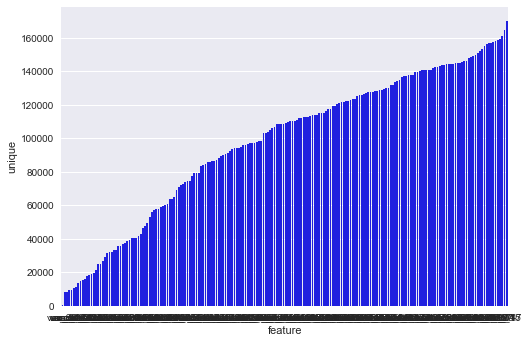

In [11]:
train_unique_df = train_df[num_vars].nunique().reset_index().\
        rename(columns={'index':'feature',0:'unique'}).\
        sort_values('unique')
sns.barplot(x='feature', y='unique',color='blue',
    data=train_unique_df)


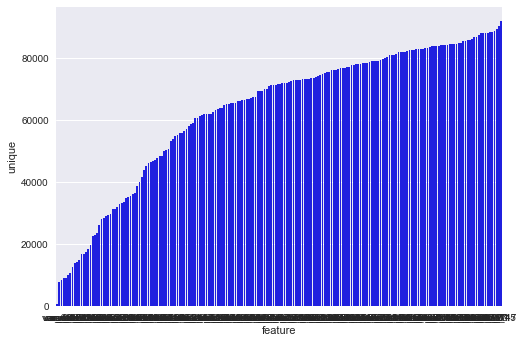

In [12]:
test_unique_df = test_df[num_vars].nunique().reset_index().\
        rename(columns={'index':'feature',0:'unique'}).\
        sort_values('unique')
sns.barplot(x='feature', y='unique',color='blue',
    data=test_unique_df)



## Feature correlation

In [13]:
corr_df = full_df[num_vars].corr()
corr_df

var_0     var_1    var_10   var_100   var_101   var_102   var_103  \
var_0    1.000000  0.001839  0.001754 -0.001270  0.001581  0.000666 -0.000887   
var_1    0.001839  1.000000  0.000752 -0.000319 -0.000812  0.000759 -0.002983   
var_10   0.001754  0.000752  1.000000 -0.001255  0.001822  0.000124 -0.000721   
var_100 -0.001270 -0.000319 -0.001255  1.000000  0.001572  0.000920 -0.001301   
var_101  0.001581 -0.000812  0.001822  0.001572  1.000000  0.001237 -0.002889   
var_102  0.000666  0.000759  0.000124  0.000920  0.001237  1.000000  0.002113   
var_103 -0.000887 -0.002983 -0.000721 -0.001301 -0.002889  0.002113  1.000000   
var_104 -0.000352  0.001253 -0.000653 -0.001390  0.000795 -0.000906  0.000758   
var_105  0.000660  0.002243 -0.000510 -0.000560  0.001824 -0.002113 -0.000373   
var_106  0.004722  0.002439  0.000145 -0.000537  0.001835  0.001855  0.000994   
var_107 -0.002201  0.000440 -0.001858  0.001141  0.000274 -0.001753  0.001623   
var_108 -0.002443 -0.002661 -0.000957  0.000473 -0.002104  0.002302  0.002248   
var_109 -0.002765 -0.000970 -0.000202  0.001171  0.002072 -0.001849  0.002365   
var_11   0.003638  0.004211  0.001414 -0.001675 -0.002544  0.000206 -0.000302   
var_110  0.003013  0.000696  0.000877 -0.004066 -0.000464 -0.001093  0.005035   
var_111 -0.000175  0.000220 -0.001887  0.000144 -0.000099 -0.000170  0.001523   
var_112  0.000208  0.000346 -0.000903 -0.000856 -0.000749 -0.001562  0.000160   
var_113 -0.001401 -0.002497 -0.001711  0.001590 -0.001171  0.000253  0.005437   
var_114  0.000633 -0.000048  0.000978  0.000832 -0.002022 -0.000525 -0.000394   
var_115 -0.002575 -0.002658  0.000516  0.000867 -0.001450  0.000969 -0.001152   
var_116 -0.001994 -0.004865 -0.000260  0.001990  0.000179 -0.001141 -0.001638   
var_117  0.000900 -0.003202  0.001558 -0.000059 -0.001644 -0.001427 -0.002913   
var_118  0.001907 -0.001577 -0.000346 -0.002329 -0.002117 -0.000499 -0.000339   
var_119  0.000373  0.002051  0.001199 -0.001349 -0.001521 -0.000080 -0.000259   
var_12  -0.003756 -0.004116 -0.000956 -0.001112  0.000698 -0.001348 -0.001504   
var_120  0.000098 -0.001282 -0.001417  0.001124 -0.000730 -0.002150  0.002560   
var_121 -0.001611 -0.000840  0.001672 -0.001290  0.000199 -0.000087  0.001443   
var_122  0.000704 -0.002204 -0.000527 -0.000998  0.003071 -0.000331 -0.000454   
var_123 -0.003362 -0.001441  0.003039  0.001317 -0.000692  0.001412  0.001440   
var_124 -0.001350  0.000644  0.000253 -0.000554  0.000221  0.002403 -0.001347   
...           ...       ...       ...       ...       ...       ...       ...   
var_72  -0.003275 -0.000267  0.002387  0.000879 -0.001020 -0.001298 -0.000194   
var_73   0.000258  0.001107 -0.000550  0.000321  0.001258  0.001515  0.003012   
var_74   0.002040  0.001240 -0.001878 -0.000525 -0.001207 -0.001568  0.002971   
var_75  -0.001456 -0.002314  0.000144  0.000713  0.001461  0.001820 -0.002452   
var_76  -0.003187 -0.000682 -0.001883  0.000495  0.002024  0.000330 -0.002449   
var_77  -0.001734 -0.001194  0.002029  0.002356  0.003209 -0.001662 -0.000720   
var_78   0.001305  0.001133  0.001917  0.002170  0.000947 -0.000726 -0.000088   
var_79  -0.000334  0.000992 -0.000026  0.000152  0.000758 -0.001463 -0.000766   
var_8    0.000652  0.002440  0.000136  0.000338 -0.002886 -0.001297 -0.001305   
var_80  -0.000085 -0.004495 -0.002666  0.001461  0.002201  0.000485 -0.001552   
var_81  -0.003040 -0.002132  0.001426 -0.000622  0.001145  0.001275  0.000700   
var_82   0.000259  0.003720  0.002124  0.000740 -0.000184 -0.001071  0.001491   
var_83  -0.000952  0.001800  0.001210  0.001531  0.002756 -0.001105 -0.001857   
var_84   0.001717 -0.000608  0.001406  0.001147  0.000660 -0.000774  0.003339   
var_85   0.002301 -0.001472  0.001387  0.002179 -0.000801  0.004599 -0.001665   
var_86  -0.000457 -0.002096  0.000682  0.001229  0.002215  0.001211  0.003333   
var_87   0.000531 -0.001522 -0.001706 -0.000196  0.002114  0.001252  0.000703   
var_88  -0.003734 -0.002470  0.001422  0.00

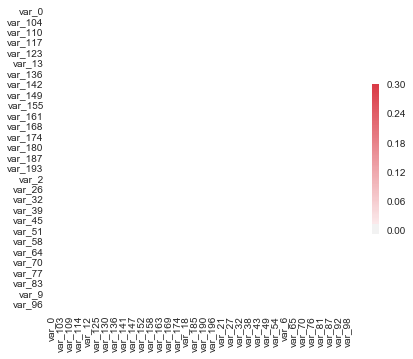

In [14]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

* ## Normality tests

Using scipy.stats.normaltest(). If p<0.05, the data is normally distributed.

In [15]:
# scipy.stats.normaltest(a,axis=0,nan_policy=’propagate’)输出结果中第一个为统计数，第二个为P值<0.05是正态
train_norm_df = train_df[num_vars].apply(lambda x:stats.normaltest(x)[1])

print("There are %d features normally distributed." % ((train_norm_df<0.05).sum())) 
# sum所有为True的，200个feature都是正态分布

print("Top 5 features with highest P value:")
train_norm_df.sort_values(ascending=False).head()

There are 200 features normally distributed.
Top 5 features with highest P value:


var_146    3.866074e-174
var_192    1.911352e-186
var_31     1.303034e-205
var_67     8.821257e-212
var_106    2.472238e-215
dtype: float64

In [16]:
test_norm_df = test_df[num_vars].apply(lambda x:stats.normaltest(x)[1])

print("There are %d features normally distributed." %((test_norm_df<0.05).sum())) #200个var都是正态分布

print("Top 5 features with highest P value:")
test_norm_df.sort_values(ascending=False).head()

There are 200 features normally distributed.
Top 5 features with highest P value:


var_146    1.080991e-155
var_31     1.095610e-205
var_192    2.242450e-210
var_124    2.295919e-215
var_106    1.115368e-216
dtype: float64

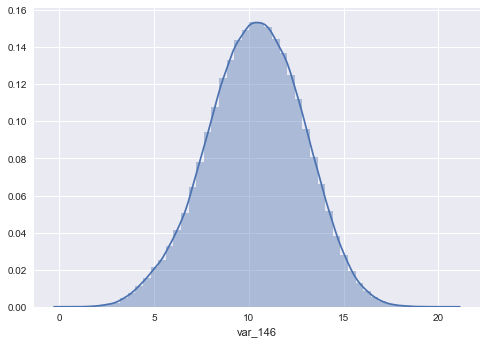

In [17]:
## Plot var_146
# seaborn.displot()查看变量分布
sns.distplot(train_df['var_146'])

* ## Pair plotting

Let's just pick 10 features and plot their interactions with target

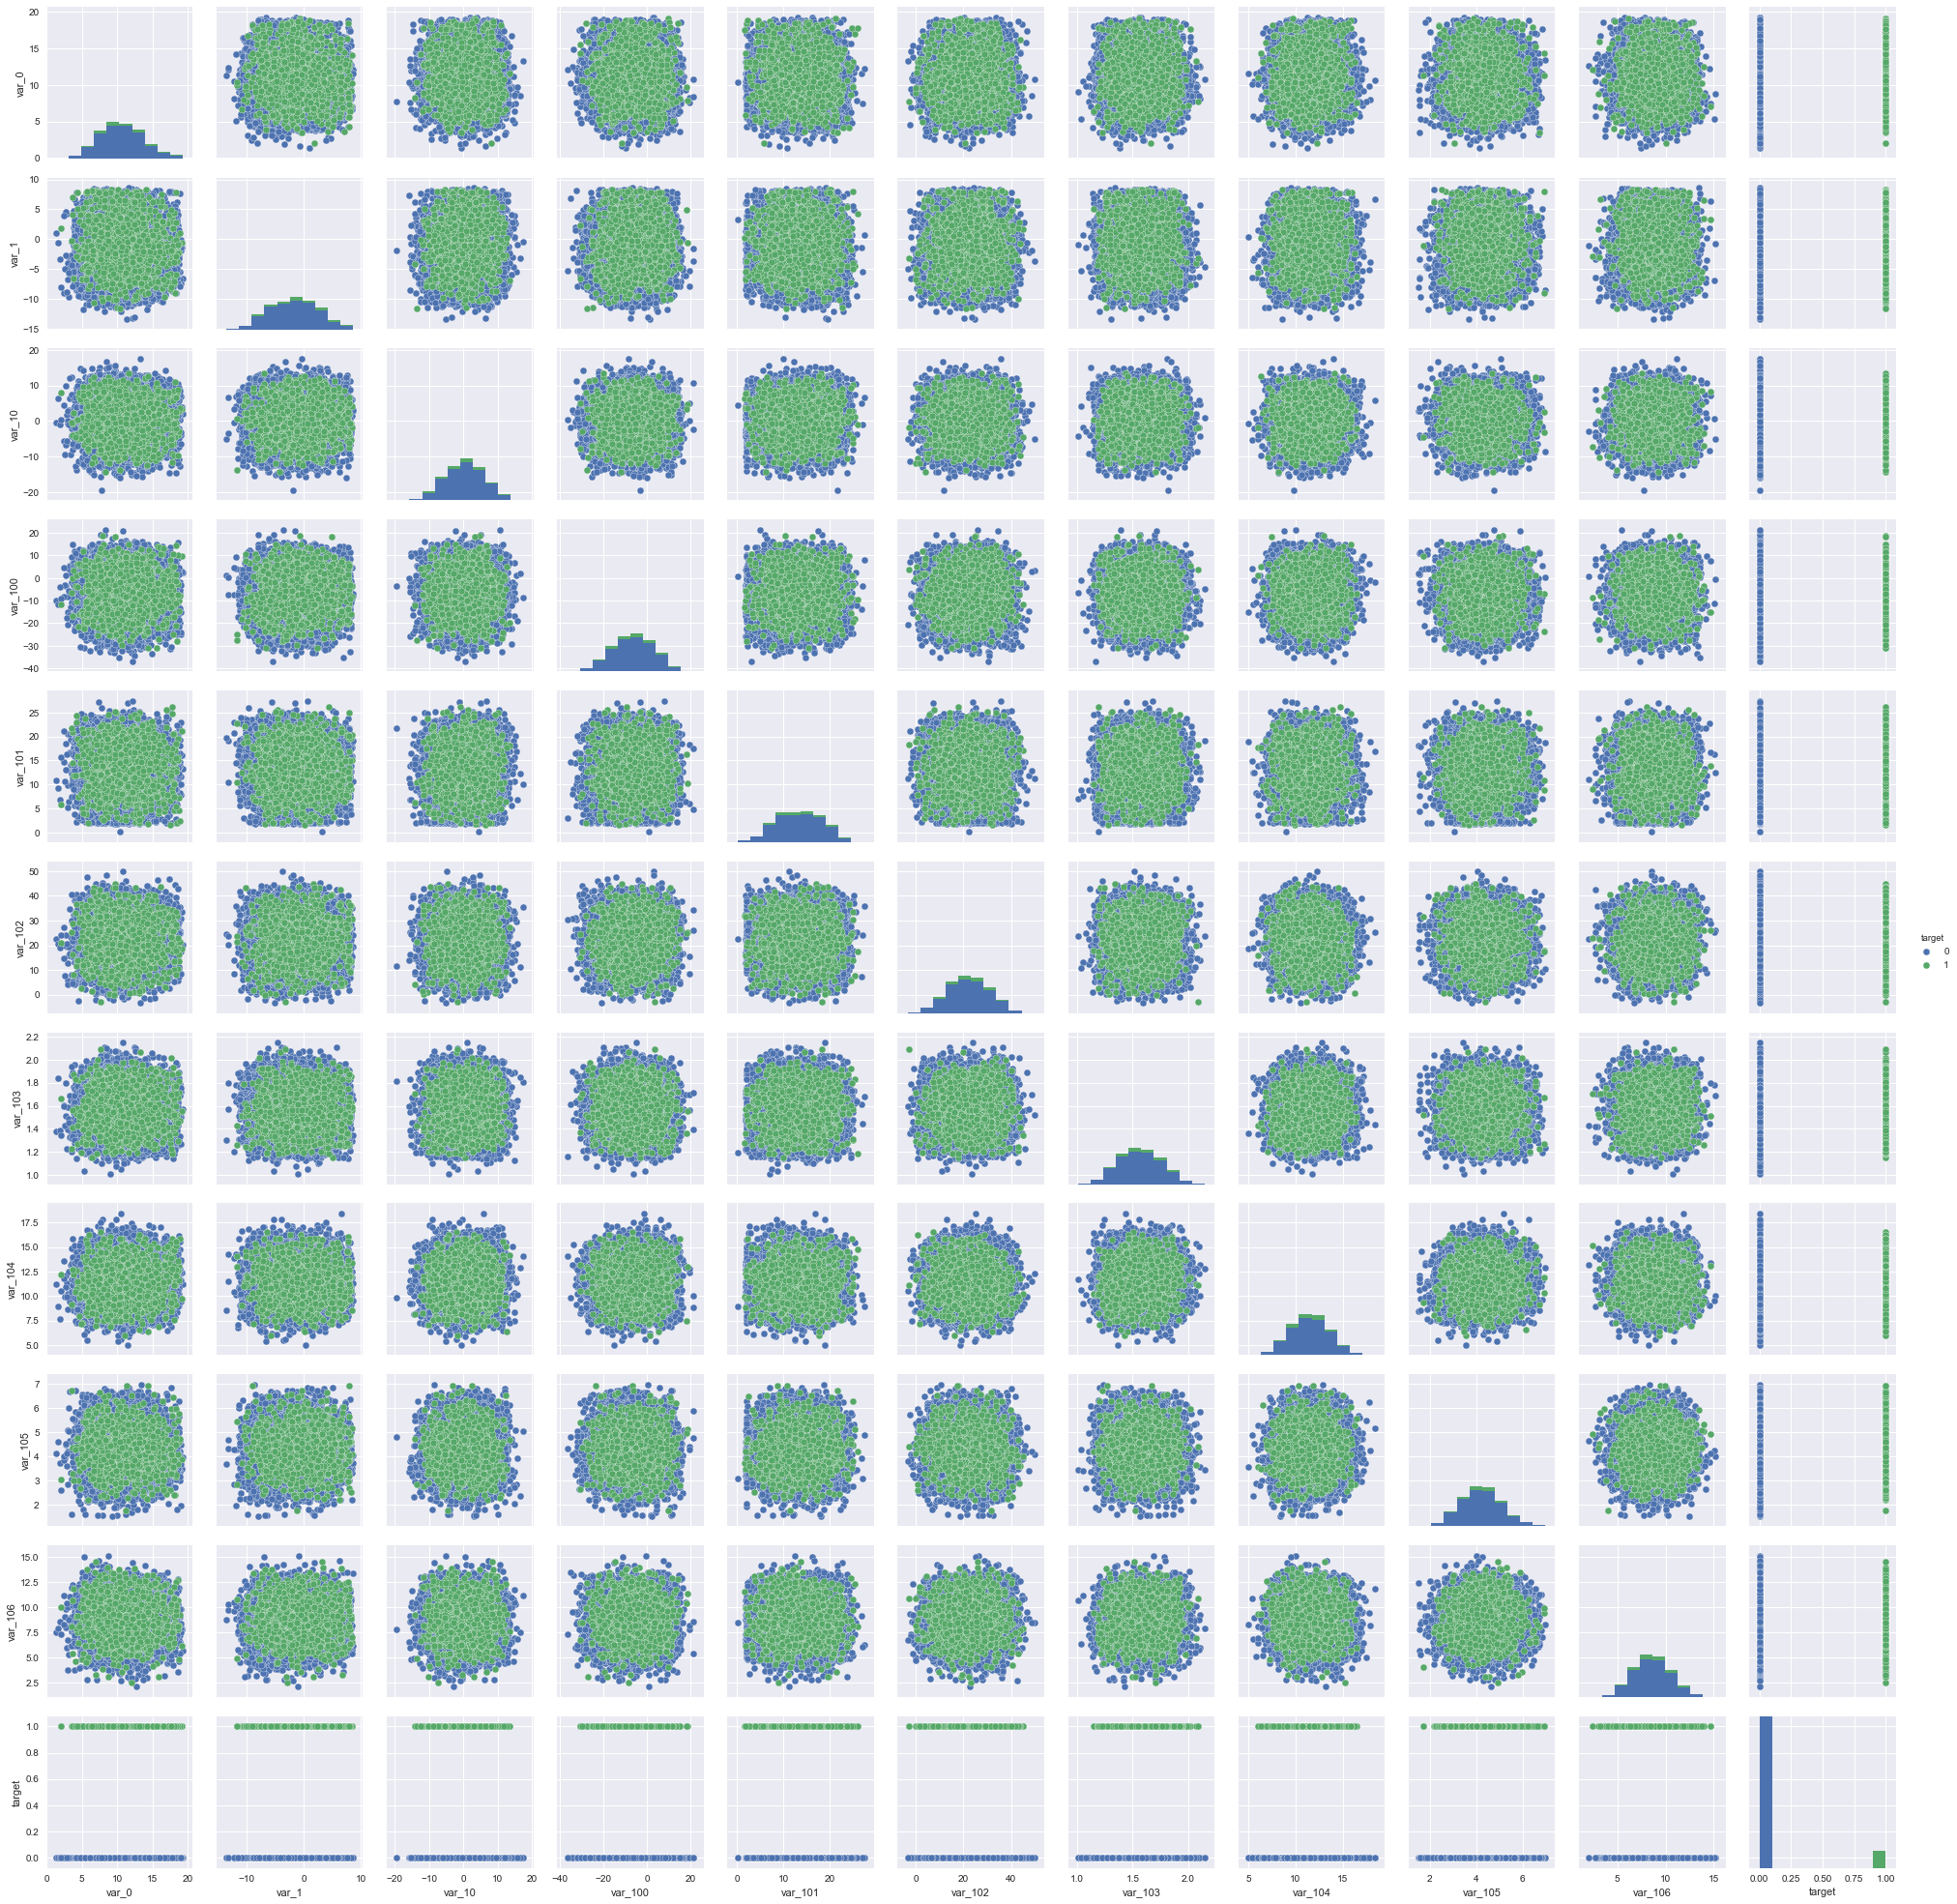

In [18]:
sns.pairplot(train_df[num_vars[:10] + ['target']][:10000], hue='target') # 前9列前10000行
# 1: green; 0: blue

## Visualization with Dimensionality Reduction


In [19]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

### TSNE

Wall time: 4min 31s


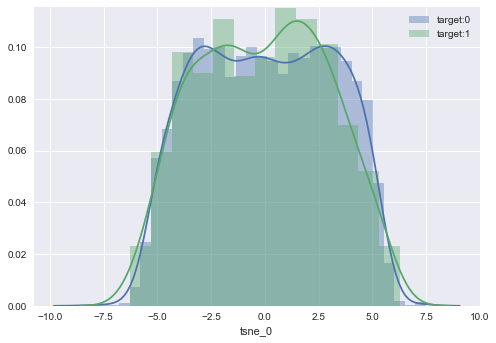

In [20]:
%%time
# 1D
tsne = TSNE(n_components=1)
tsne1d = tsne.fit_transform(train_df[num_vars][:10000].values)
tsne1d_df = pd.DataFrame({'tsne_0':tsne1d.reshape(-1), 'target':train_df['target'][:10000].values})

sns.distplot(tsne1d_df.query('target==0')['tsne_0'], label='target:0')
sns.distplot(tsne1d_df.query('target==1')['tsne_0'], label='target:1')
plt.legend()

Wall time: 8min 50s


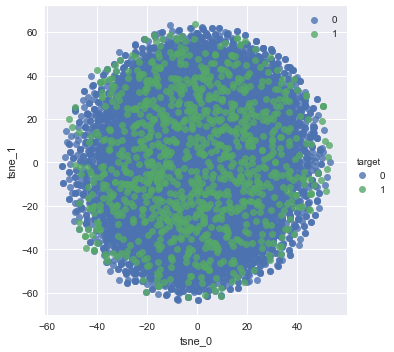

In [21]:
%%time
## 2D
tsne = TSNE(n_components=2)
tsne2d = tsne.fit_transform(train_df[num_vars][:10000].values)
tsne2d_df = pd.DataFrame({'tsne_0':tsne2d[:,0],'tsne_1':tsne2d[:,1], 
                          'target':train_df['target'][:10000].values})
sns.lmplot(x='tsne_0', y='tsne_1', data=tsne2d_df, hue='target', fit_reg=False)
plt.legend()

### PCA

[0.07161387 0.03112503]
[459.81153666 199.84459989]
Wall time: 598 ms


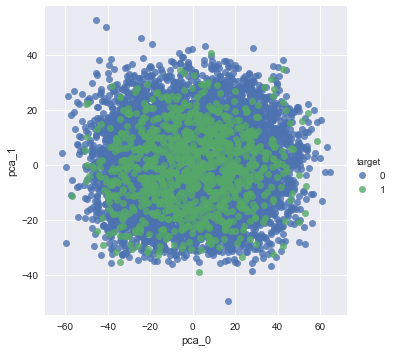

In [22]:
%%time
## 2D
pca = PCA(n_components=2) # 降维后的主成成分数量，如果没有设置，使用所有维度
pca2d = pca.fit_transform(train_df[num_vars][:10000].values)
print (pca.explained_variance_ratio_) #[0.07161387 0.0311255 ]
print (pca.explained_variance_) # [459.81153666 199.8476584 ] 方差大的好

pca2d_df = pd.DataFrame({'pca_0':pca2d[:,0],
                         'pca_1':pca2d[:,1], 
                          'target':train_df['target'][:10000].values})

sns.lmplot(x='pca_0', y='pca_1', data=pca2d_df, hue='target', fit_reg=False)


### TruncatedSVD

Wall time: 675 ms


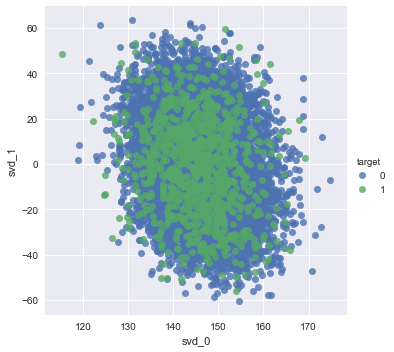

In [23]:
%%time
## 2D
svd = TruncatedSVD(n_components=2)
svd2d = svd.fit_transform(train_df[num_vars][:10000].values)
svd2d_df = pd.DataFrame({'svd_0':svd2d[:,0],'svd_1':svd2d[:,1], 
                          'target':train_df['target'][:10000].values})
sns.lmplot(x='svd_0', y='svd_1', data=svd2d_df, hue='target', fit_reg=False)



# Feature engineering

Unfortunately most of the feature engineering techiniques didn't seem to work in this task for tree-based models. However, feature scallings are still quite effective for linear models (including NN models). 

## Standardization

In [24]:
std_scaler = StandardScaler()
# Notice we are using full datasets in order to capture more information
std_scaler.fit(full_df[num_vars].values) 

train_std_df = pd.DataFrame(std_scaler.transform(train_df[num_vars].values), columns=num_vars)
test_std_df = pd.DataFrame(std_scaler.transform(test_df[num_vars].values) , columns=num_vars)

train_std_df['target'] = train_df['target'].values

In [25]:
train_std_df[num_vars].describe()

var_0          var_1         var_10        var_100  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.003485      -0.000418       0.002090       0.004002   
std         1.000545       1.001180       0.999285       0.999997   
min        -3.377088      -3.316829      -3.835638      -3.544201   
25%        -0.729160      -0.769811      -0.722613      -0.714620   
50%        -0.047583       0.004421       0.018977       0.025678   
75%         0.687493       0.737790       0.726664       0.737266   
max         3.174596       2.967103       3.322120       3.461028   

             var_101        var_102        var_103        var_104  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.002444      -0.002287      -0.000848      -0.003369   
std         0.999714       0.999849       0.999257       0.999070   
min        -2.691005      -3.441403      -3.182431      -3.768027   
25%        -0.759625      -0.726192      -0.754222      -0.719232   
50%        -0.004155      -0.000903      -0.013770      -0.009395   
75%         0.777229       0.737887       0.739104       0.702521   
max         3.040817       3.361945       3.349320       3.804654   

             var_105        var_106      ...               var_90  \
count  200000.000000  200000.000000      ...        200000.000000   
mean        0.000253      -0.000897      ...            -0.008097   
std         0.998822       1.001121      ...             0.999133   
min        -4.119525      -4.055921      ...            -3.439355   
25%        -0.706107      -0.706398      ...            -0.776653   
50%        -0.023377      -0.007504      ...            -0.003117   
75%         0.674294       0.691865      ...             0.762080   
max         3.413853       3.533457      ...             3.320580   

              var_91         var_92         var_93         var_94  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       -0.002200       0.000483      -0.000167       0.001808   
std         0.998041       0.998480       1.000979       1.000441   
min        -3.047450      -3.281013      -3.804703      -2.954650   
25%        -0.771399      -0.731583      -0.665482      -0.782889   
50%        -0.009010      -0.015277       0.046738      -0.003726   
75%         0.742264       0.740031       0.714927       0.757149   
max         3.279854       3.401223       3.643024       2.884419   

              var_95         var_96         var_97         var_98  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.003576      -0.001461      -0.002516       0.000223   
std         1.003213       0.998397       0.998732       1.001429   
min        -3.788895      -3.111725      -3.184557      -3.295054   
25%        -0.712027      -0.774785      -0.762494      -0.677347   
50%        -0.019450      -0.005036      -0.005478       0.023009   
75%         0.671352       0.750252       0.757399       0.712139   
max         3.053542       3.099592       3.137546       3.848478   

              var_99  
count  200000.000000  
mean       -0.000167  
std         0.998333  
min        -3.502577  
25%        -0.729080  
50%        -0.013569  
75%         0.683128  
max         3.120819  

[8 rows x 200 columns]

Standardized features have 0 mean and 1 std.

### Cross validation with raw feature

In [26]:
# cross_val_score 交叉验证 - 用来看标准化之后模型的表现有没有提高

from sklearn.model_selection import cross_val_score

train_x = train_df[num_vars].values
train_y = train_df['target'].values
test_x = test_df[num_vars].values


lr_cv_raw = cross_val_score(LogisticRegression(),    # model= LogisticRegression
                            train_x[:10000], train_y[:10000], 
                            scoring = 'roc_auc',  # 'accuracy'， 'mean_squared_error'
                            cv=5,    # cross_val_score采用的是k-fold cross validation方法，重复5次交叉验证
                            n_jobs = -1)  #同时工作的cpu个数（-1代表全部）

print("Logistic regression CV score with raw features:", lr_cv_raw.mean())


Logistic regression CV score with raw features: 0.8248206091403943


### Cross validation with standardized features

In [27]:
%%time
train_x = train_std_df[num_vars].values
train_y = train_std_df['target'].values
test_x = test_std_df[num_vars].values

lr_cv_std = cross_val_score(LogisticRegression(), 
                            train_x[:10000], train_y[:10000], 
                            scoring='roc_auc',
                            cv=5, 
                            n_jobs=-1)

print("Logistic regression CV score with standardized features:", lr_cv_std.mean())

# 所以做std对线性模型既能帮助提高性能，也能提高速度

Logistic regression CV score with standardized features: 0.8258862572839574
Wall time: 4.22 s


both training time and cross validation score have improved with feature standardization

#### Visualization 

Wall time: 557 ms


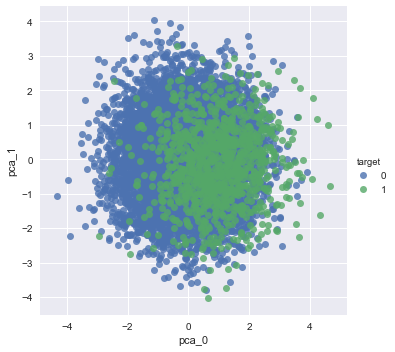

In [28]:
%%time
## 2D
pca = PCA(n_components=2)
pca2d = pca.fit_transform(train_std_df[num_vars][:10000].values)
pca2d_df = pd.DataFrame({'pca_0':pca2d[:,0],'pca_1':pca2d[:,1], 
                          'target':train_df['target'][:10000].values})
sns.lmplot(x='pca_0', y='pca_1', data=pca2d_df, hue='target', fit_reg=False)

# std转换后pca的趋势更明显，比起前面target绿色更集中分布在中心里面

Wall time: 428 ms


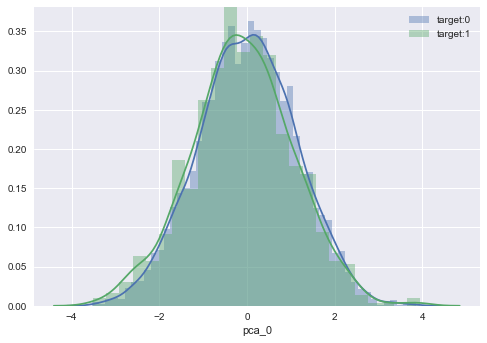

In [29]:
%%time
# 1D
pca = PCA(n_components=1)
pca1d = pca.fit_transform(train_std_df[num_vars][:10000].values)
pca1d_df = pd.DataFrame({'pca_0':pca1d.reshape(-1), 'target':train_df['target'][:10000].values})
sns.distplot(pca1d_df.query('target==0')['pca_0'], label='target:0')
sns.distplot(pca1d_df.query('target==1')['pca_0'], label='target:1')
plt.legend()

## Could the data be a hypersphere?

calculate the L2 norm (euclidean distance) of each sample and plot it against target and see how it looks like:

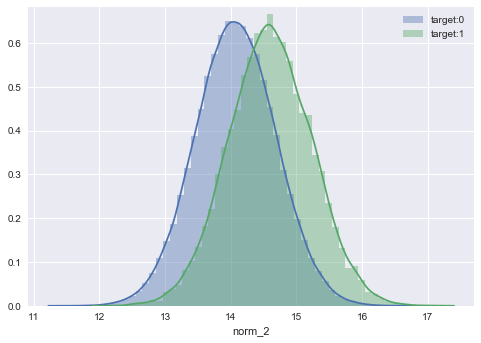

In [30]:
# 对于每一条记录，我们计算L2的模（平方和开根），也就是它们到原点的欧氏距离

# 1D

train_std_df['norm_2'] = train_std_df[num_vars].apply(lambda x:np.linalg.norm(x), axis=1)
test_std_df['norm_2'] = test_std_df[num_vars].apply(lambda x:np.linalg.norm(x), axis=1)
# np.linalg.norm(x, ord=2) ord=2二范数 (x1²+x2²+...)^2

sns.distplot(train_std_df.query('target==0')['norm_2'], label='target:0')
sns.distplot(train_std_df.query('target==1')['norm_2'], label='target:1')
plt.legend()

Further more, this feature solely can get a ROCAUC score 0.72!

In [31]:
roc_auc_score(train_y, train_std_df['norm_2'])
# 很高，说明里面已经有很强的规则在里面了

# roc_auc_score(y_true, y_score, average=’macro’, sample_weight=None, max_fpr=None)
# y_true: 真实的标签
# y_score: 预测得分，可以是正类的估计概率、置信值或者分类器方法

0.7257182728555327

## Feature importance

### Feature importance from Logistic Regression

In [32]:
# Logistic Regression - importance从coef里面来

train_x = train_std_df[num_vars].values
train_y = train_std_df['target'].values
test_x = test_std_df[num_vars].values

lr = LogisticRegression(solver='lbfgs')
lr.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
lr_feature_importance = pd.DataFrame({'feature':num_vars, 'lr_importance':lr.coef_.reshape(-1), 
                                      'abs_lr_importance': abs(lr.coef_.reshape(-1))})
                            
lr_feature_importance.sort_values('abs_lr_importance', ascending=False).head()

feature  lr_importance  abs_lr_importance
180   var_81      -0.256267           0.256267
45   var_139      -0.236217           0.236217
156    var_6       0.225167           0.225167
24    var_12      -0.219592           0.219592
149   var_53       0.212913           0.212913

### Feature importance from LightGBM

In [34]:
# LightGBM - importance按照某一个特征在构建决策树的过程中参与分裂的次数来决定的，分裂次数越多越重要

lgb_clf = lgb.LGBMClassifier(n_jobs=-1)
lgb_clf.fit(train_x, train_y)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [35]:
lgb_feature_importance = pd.DataFrame({'feature':num_vars, 
                                       'lgb_importance':lgb_clf.feature_importances_.reshape(-1)})
                                        
lgb_feature_importance.sort_values('lgb_importance', ascending=False).head()

feature  lgb_importance
84   var_174              56
149   var_53              51
75   var_166              48
174   var_76              48
128   var_34              47

### Combined feature importance

In [36]:
feature_importance = pd.merge(lr_feature_importance, lgb_feature_importance, on='feature')
feature_importance.head()

feature  lr_importance  abs_lr_importance  lgb_importance
0    var_0       0.167472           0.167472              36
1    var_1       0.164225           0.164225              40
2   var_10      -0.004925           0.004925               0
3  var_100       0.006457           0.006457               0
4  var_101      -0.031786           0.031786               1

#### var_53 was considered as very important by both LR and LGB

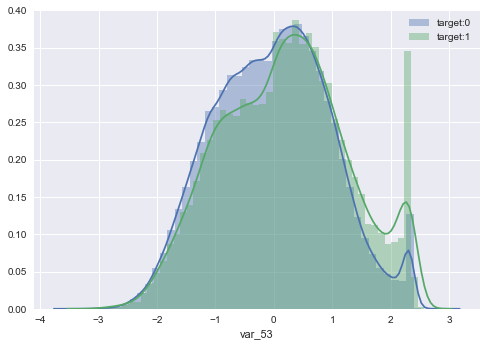

In [41]:
# var_53 against target
sns.distplot(train_std_df.query('target==0')['var_53'], label='target:0')
sns.distplot(train_std_df.query('target==1')['var_53'], label='target:1')
plt.legend()

## 合起来看能看出target=1在右边的峰值上有一个明显的凸出来的分布

## 推测会不会是多个（3个以上）高斯分布叠加，每一个的1和0（蓝色/绿色）的分布是不一样的?
## 猜测用一个gaussian mixture model来学习，并且estimate3个分布各自的mean/std，在根据这个来确定每个分布的概率，
 # 再把概率作为一个特征加到模型里面


#### Another important feature: var_81 

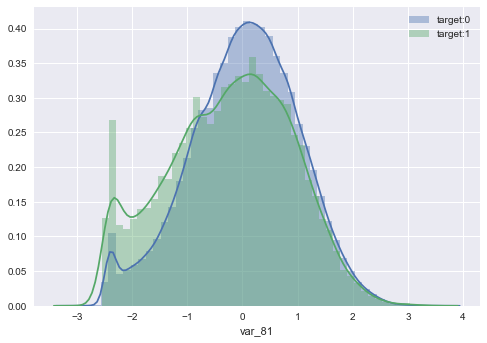

In [42]:
# var_81 against target
sns.distplot(train_std_df.query('target==0')['var_81'], label='target:0')
sns.distplot(train_std_df.query('target==1')['var_81'], label='target:1')
plt.legend()

# Training our first model - LightGBM

In [43]:
lgb_params = {
    "learning_rate" : 0.01, # 学习率先定一个较高的值
    "boosting": 'gbdt',     # 估计器estimater的类型
#  "n_estimators/num_iterations/num_round/num_boost_round" ：100000
# 估计器的数目 = boosting迭代的次数 = 残差树的数目,先设成一个较大的数，然后在cv结果中查看最优的迭代次数
    "boost_from_average": "false",
    "objective" : "binary",  # binary log loss classification。其他比如'objective': regression'，'metric': 'rmse'等等
    "metric" : "auc",
    
    "max_depth" : -1,  # 树深度，深度越大可能过拟合
    "num_leaves" : 15, # 因为LightGBM 使用leaf-wise算法，因此在调节树的复杂程度时，使用的是 num_leaves 而不是 max_depth.
    #大致换算关系：num_leaves = 2^(max_depth)，但是它的值的设置应该小于 2^(max_depth)，否则可能会导致过拟合
    
    "feature_fraction" : 0.7, # 进行特征的子抽样,这个参数可以用来防止过拟合及提高训练速度
    #bagging_fraction + bagging_freq参数必须同时设置
    "bagging_fraction" : 0.8,  # 相当于subsample样本采样，可以使bagging更快的运行，同时也可以降拟合
    "bagging_freq": 1,         # 默认0，表示bagging的频率，0意味着没有使用bagging，k意味着每k轮迭代进行一次bagging

    "verbosity" : 1,
    "seed": 42
}

# StratifiedKFold用法类似Kfold，但是他是分层采样，确保训练集，测试集中各类别样本的比例与原始数据集中相同
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
oof = train_df[['ID_code', 'target']]
oof['predict'] = 0
predictions = test_df[['ID_code']]
val_aucs = []
feature_importance_df = pd.DataFrame()

X_test = test_std_df[num_vars]


# enumerate()将一个可遍历的数据对象(如列表/元组/字符串)组合为一个索引序列，同时列出数据和数据下标，一般用在for循环中
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_std_df, train_std_df['target'])):
    X_train, y_train = train_std_df.iloc[trn_idx][num_vars], train_std_df.iloc[trn_idx]['target']
    X_valid, y_valid = train_std_df.iloc[val_idx][num_vars], train_std_df.iloc[val_idx]['target']
     
    # create dataset for lightgbm 
    trn_data = lgb.Dataset(X_train, label = y_train)
    val_data = lgb.Dataset(X_valid, label = y_valid)
    evals_result = {}
    
    lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        100000,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds =3000,
                        verbose_eval = 1000,
                        evals_result = evals_result
                       )
    
    # 把 lgb.train出来的结果整理成dataframe
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = num_vars
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # predict验证集
    p_valid = lgb_clf.predict(X_valid)
    oof['predict'][val_idx] = p_valid
    
    # 计算验证集的auc
    '''
    #画roc曲线：sklearn.metrics.roc_curve(y_true, y_score,
                                        pos_label = None,
                                        sample_weight = None,
                                        drop_intermediate = True)
    #计算aucm面积：sklearn.metrics.roc_auc_score(y_true, y_score, 
                                                average = 'macro', 
                                                sample_weight = None)
    '''
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
    # predict测试集
    predictions['fold{}'.format(fold+1)] = lgb_clf.predict(X_test)

    

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.894033	valid_1's auc: 0.863473
[2000]	training's auc: 0.923783	valid_1's auc: 0.88478
[3000]	training's auc: 0.938117	valid_1's auc: 0.892549
[4000]	training's auc: 0.947802	valid_1's auc: 0.895826
[5000]	training's auc: 0.956339	valid_1's auc: 0.897261
[6000]	training's auc: 0.964123	valid_1's auc: 0.897765
[7000]	training's auc: 0.970885	valid_1's auc: 0.898118
[8000]	training's auc: 0.976695	valid_1's auc: 0.898189
[9000]	training's auc: 0.98148	valid_1's auc: 0.898307
[10000]	training's auc: 0.985283	valid_1's auc: 0.898295
[11000]	training's auc: 0.988369	valid_1's auc: 0.898368
[12000]	training's auc: 0.990884	valid_1's auc: 0.898351
[13000]	training's auc: 0.992924	valid_1's auc: 0.898285
[14000]	training's auc: 0.994554	valid_1's auc: 0.898267
Early stopping, best iteration is:
[11112]	training's auc: 0.988678	valid_1's auc: 0.898402
Training until validation scores don't improve for 3000 r

In [45]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))
# 不是特别好的auc

Mean auc: 0.897841955, std: 0.001041936. All auc: 0.897788089.


In [46]:
predictions['target'] = np.mean(predictions[[col for col in predictions.columns 
                                             if col not in ['ID_code', 'target']]].values, 
                                axis=1)

sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = predictions['target']

print(predictions.head())
print(sub_df.head())

sub_df.to_csv("lgb_submission.csv", index=False)

  ID_code     fold1     fold2     fold3     fold4     fold5    target
0  test_0  0.071489  0.092948  0.072736  0.067248  0.059221  0.072728
1  test_1  0.253201  0.326849  0.210368  0.161237  0.227707  0.235873
2  test_2  0.236211  0.215436  0.208539  0.151222  0.231226  0.208527
3  test_3  0.161638  0.113761  0.147498  0.154963  0.253605  0.166293
4  test_4  0.038854  0.039459  0.034496  0.052732  0.034091  0.039927
  ID_code    target
0  test_0  0.072728
1  test_1  0.235873
2  test_2  0.208527
3  test_3  0.166293
4  test_4  0.039927


# Model tuning

## LightGBM

### Manual tuning


In [48]:
gc.collect() # 释放内存
print ("starting....")

full_vars = num_vars
cat_vars = None

full_vars = num_vars
train_x = train_df[full_vars].values
train_y = train_df[target_var].values
test_x = test_df[full_vars].values

import copy
default_lgb_params = {}
default_lgb_params["learning_rate"] = 0.1 
# 学习率learning_rate先用较大的0.1来调，则需要的num of trees就少一些，下面的参数调完了以后再把0.1改回小一点，分数就变高了
default_lgb_params["objective"] = "binary"
default_lgb_params["boost_from_average"] = "false"
default_lgb_params["metric"] = 'auc'
default_lgb_params["bagging_freq"] = 1
default_lgb_params["seed"] = 42

params_lgb_space = {}
params_lgb_space['num_leaves'] = [2, 4, 8, 16, 32]  # 普通情况先从num_leaves来调
params_lgb_space['max_depth'] = [3 ,4 ,5 ,6, -1]
params_lgb_space['min_gain_to_split'] = [0, 0.1, 0.3, 1, 1.5, 2, 3] # 默认0，执行切分的最小增益
params_lgb_space['min_sum_hessian_in_leaf'] = [1, 5, 10, 30, 100]   # = min_child_weight，使一个结点分裂的最小海森值之和
params_lgb_space['feature_fraction'] = np.arange(0.1, 1, 0.1)
params_lgb_space['bagging_fraction'] = np.arange(0.1, 1, 0.1)
params_lgb_space['lambda_l2'] = [0, 0.01, 0.1, 1, 10, 100, 300] #正则化参数是用来降低过拟合的。lambda_l1(reg_alpha),L1正则化
params_lgb_space['lambda_l1'] = [0, 0.01, 0.1, 1, 10, 100, 300] #lambda_l2(reg_lambda),L2正则化

print("default_lgb_params \n",default_lgb_params ,'\n')
print("params_lgb_space \n", params_lgb_space,'\n')


greater_is_better = True

best_lgb_params = copy.copy(default_lgb_params)
# copy.copy: shallow copy 并未从原object真的独立出来,原object的子list中的一个元素，你的copy就会跟着一起变
# deep copy: 复制出来就独立了，改变copy版，原objetc不会变

for p in params_lgb_space: #p为变量名，params_lgb_space['feature_fraction']=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    print ("\n Tuning parameter %s in %s" % (p, params_lgb_space[p]))
    params = best_lgb_params
    scores = []    
    for v in params_lgb_space[p]: # v = 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 in每一个feature
        gc.collect()
        print ('\n    %s: %s' % (p, v), end="\n")
        params[p] = v

        # lgb.cv 交叉验证
        cv_results = lgb.cv(params, #超参数
                        lgb.Dataset(train_x, label=train_y), #训练集
                        stratified =True,
                        shuffle =True,
                        nfold =5,
                        num_boost_round = 100000,
                        early_stopping_rounds =100,
                        verbose_eval=0)
       # 为了实现提前停止的交叉验证，我们使用LightGBM函数cv，它输入为超参数，训练集，用于交叉验证的折数等
       # 将迭代次数num_boost_round设为10000，但实际不会达到这个数字，因为我们用early_stopping_rounds来停止训练，
       # 当连续100轮迭代后都没有提升时，则提前停止,并选择模型。因此，迭代次数并不是我们需要设置的超参数。

        #一旦交叉验证完成，我们就会得到最好的分数roc-auc,然后返回这个值
        best_lgb_score = max(cv_results['auc-mean'])
        print ('Score: %f ' % (best_lgb_score))
        scores.append([v, best_lgb_score])

    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_lgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

    
best_param_value = sorted(scores, key=lambda x:x[1],reverse = greater_is_better)[0][0]
best_param_score = sorted(scores, key=lambda x:x[1],reverse = greater_is_better)[0][1]
best_lgb_params[p] = best_param_value
print ("\n Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))
print ('\n Best manually tuned parameters:', best_lgb_params)   


starting....
default_lgb_params 
 {'learning_rate': 0.1, 'objective': 'binary', 'boost_from_average': 'false', 'metric': 'auc', 'bagging_freq': 1, 'seed': 42} 

params_lgb_space 
 {'num_leaves': [2, 4, 8, 16, 32], 'max_depth': [3, 4, 5, 6, -1], 'min_gain_to_split': [0, 0.1, 0.3, 1, 1.5, 2, 3], 'min_sum_hessian_in_leaf': [1, 5, 10, 30, 100], 'feature_fraction': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'bagging_fraction': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'lambda_l2': [0, 0.01, 0.1, 1, 10, 100, 300], 'lambda_l1': [0, 0.01, 0.1, 1, 10, 100, 300]} 


 Tuning parameter num_leaves in [2, 4, 8, 16, 32]

    num_leaves: 2
Score: 0.898834 

    num_leaves: 4
Score: 0.895905 

    num_leaves: 8
Score: 0.893160 

    num_leaves: 16
Score: 0.890617 

    num_leaves: 32
Score: 0.888157 
Best num_leaves is 2 with a score of 0.898834

 Tuning parameter max_depth in [3, 4, 5, 6, -1]

    max_depth: 3
Score: 0.898834 

    max_depth: 4
Score: 0.898834 

    max_depth: 5

In [49]:

sorted(scores, key=lambda x:x[1],reverse = greater_is_better)
# key=lambda x: x[1] 为对前面的对象中的第二维数据（即value）的值进行排序


[[0, 0.8994780663293195],
 [0.1, 0.8991128328337282],
 [0.01, 0.8991061632484557],
 [10, 0.8989725205163367],
 [1, 0.8989092566141845],
 [100, 0.818888184699509],
 [300, 0.5]]

In [50]:
print("lgb scores = best cv_results = max auc-mean \n",scores, "\n")
print("cv_results \n",cv_results.keys())
print("cv_results \n",cv_results)

lgb scores = best cv_results = max auc-mean 
 [[0, 0.8994780663293195], [0.01, 0.8991061632484557], [0.1, 0.8991128328337282], [1, 0.8989092566141845], [10, 0.8989725205163367], [100, 0.818888184699509], [300, 0.5]] 

cv_results 
 dict_keys(['auc-mean', 'auc-stdv'])
cv_results 
 {'auc-mean': [0.5], 'auc-stdv': [0.0]}


## Retrain the model with manually tuned parameters


In [51]:
best_param_value = {'learning_rate': 0.1, 'metric': 'auc', 
                    'seed': 42, 'objective': 'binary','boost_from_average':'false',
                    'feature_fraction': 0.1, 'bagging_freq': 1, 
                    'num_leaves': 2, 'max_depth': 3, 'min_gain_to_split': 0, 
                    'bagging_fraction': 0.4, 'min_sum_hessian_in_leaf': 30, 
                    'lambda_l2': 0.01, 'lambda_l1': 0.01}

#前面用较大的0.1来调，则需要的num of trees就少一些，调完了以后得出的这组参数，再把0.1改回小一点，分数就变高了
best_param_value['learning_rate'] = 0.01


In [52]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
oof = train_df[['ID_code', 'target']]
oof['predict'] = 0
predictions = test_df[['ID_code']]
val_aucs = []
feature_importance_df = pd.DataFrame()

X_test = test_df[num_vars]


for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    X_train, y_train = train_df.iloc[trn_idx][num_vars], train_df.iloc[trn_idx]['target']
    X_valid, y_valid = train_df.iloc[val_idx][num_vars], train_df.iloc[val_idx]['target']
    
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    evals_result = {}
    
    lgb_clf = lgb.train(best_param_value,
                        trn_data,
                        100000,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds=3000,
                        verbose_eval = 1000,
                        evals_result=evals_result
                       )
    
    # training's auc: 0.913896	valid_1's auc: 0.898719
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = num_vars
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    p_valid = lgb_clf.predict(X_valid)
    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
    predictions['fold{}'.format(fold+1)] = lgb_clf.predict(X_test)

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.797261	valid_1's auc: 0.79345
[2000]	training's auc: 0.83256	valid_1's auc: 0.828059
[3000]	training's auc: 0.852583	valid_1's auc: 0.847246
[4000]	training's auc: 0.864037	valid_1's auc: 0.858452
[5000]	training's auc: 0.872489	valid_1's auc: 0.866349
[6000]	training's auc: 0.878627	valid_1's auc: 0.872008
[7000]	training's auc: 0.883349	valid_1's auc: 0.876579
[8000]	training's auc: 0.887316	valid_1's auc: 0.880262
[9000]	training's auc: 0.890509	valid_1's auc: 0.883324
[10000]	training's auc: 0.893039	valid_1's auc: 0.885677
[11000]	training's auc: 0.895448	valid_1's auc: 0.887955
[12000]	training's auc: 0.897383	valid_1's auc: 0.889719
[13000]	training's auc: 0.899058	valid_1's auc: 0.89111
[14000]	training's auc: 0.900457	valid_1's auc: 0.892275
[15000]	training's auc: 0.901763	valid_1's auc: 0.89356
[16000]	training's auc: 0.902863	valid_1's auc: 0.894498
[17000]	training's auc: 0.903917	vali

[15000]	training's auc: 0.902102	valid_1's auc: 0.893579
[16000]	training's auc: 0.903215	valid_1's auc: 0.894447
[17000]	training's auc: 0.90422	valid_1's auc: 0.895252
[18000]	training's auc: 0.905122	valid_1's auc: 0.895883
[19000]	training's auc: 0.905938	valid_1's auc: 0.896543
[20000]	training's auc: 0.906619	valid_1's auc: 0.896999
[21000]	training's auc: 0.907259	valid_1's auc: 0.89742
[22000]	training's auc: 0.907822	valid_1's auc: 0.897763
[23000]	training's auc: 0.908359	valid_1's auc: 0.898142
[24000]	training's auc: 0.90884	valid_1's auc: 0.898442
[25000]	training's auc: 0.909279	valid_1's auc: 0.898646
[26000]	training's auc: 0.909667	valid_1's auc: 0.898866
[27000]	training's auc: 0.91005	valid_1's auc: 0.899037
[28000]	training's auc: 0.910378	valid_1's auc: 0.89918
[29000]	training's auc: 0.910687	valid_1's auc: 0.899349
[30000]	training's auc: 0.91096	valid_1's auc: 0.899487
[31000]	training's auc: 0.911231	valid_1's auc: 0.899525
[32000]	training's auc: 0.911484	vali

In [54]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.900434645, std: 0.001111653. All auc: 0.900402356.


In [55]:
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = predictions['target']

print(sub_df.head())

sub_df.to_csv("lgb_sub_manual_tuned.csv", index=False)

  ID_code    target
0  test_0  0.096663
1  test_1  0.211563
2  test_2  0.203613
3  test_3  0.172851
4  test_4  0.042755


### Automated tuning


In [56]:
train_x = train_df[num_vars].values
train_y = train_df['target'].values

In [57]:
from bayes_opt import BayesianOptimization


def lgb_evaluate(
    num_leaves,
    max_depth,
    min_sum_hessian_in_leaf,
    min_gain_to_split,
    feature_fraction,
    bagging_fraction,
    lambda_l2,
    lambda_l1
):
    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.1
    params['seed'] = 1234
    params['num_leaves'] = int(num_leaves)
    params['max_depth'] = int(max_depth)
    params['min_sum_hessian_in_leaf'] = int(min_sum_hessian_in_leaf)
    params['min_gain_to_split'] = min_gain_to_split
    params['feature_fraction'] = feature_fraction
    params['bagging_fraction'] = bagging_fraction
    params['bagging_freq'] = 1
    params['lambda_l2'] = lambda_l2
    params['lambda_l1'] = lambda_l1
    params["metric"] = 'auc'

    cv_results = lgb.cv(params,
                        lgb.Dataset(train_x, label=train_y),
                        stratified=True,
                        shuffle=True,
                        nfold=5,
                        num_boost_round=100000,
                        early_stopping_rounds=100,
                        verbose_eval=0)
    best_lgb_score = max(cv_results['auc-mean'])
    print ('Score: %f ' % (best_lgb_score))
    return best_lgb_score


lgb_BO = BayesianOptimization(lgb_evaluate,
                              {
                                  'num_leaves': (2,72),
                                  'max_depth': (-1, -1),
                                  'min_sum_hessian_in_leaf': (0, 100),
                                  'min_gain_to_split': (0, 100),
                                  'feature_fraction': (0.005, 0.1),
                                  'bagging_fraction': (0.3, 0.7),
                                  'lambda_l2': (0, 1),
                                  'lambda_l1': (0, 1)
                              }
                              )

lgb_BO.maximize(init_points=3, n_iter=7)


|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
Score: 0.854383 
|  1        |  0.8544   |  0.4008   |  0.02489  |  0.7955   |  0.6103   | -1.0      |  80.1     |  8.452    |  23.59    |
Score: 0.858235 
|  2        |  0.8582   |  0.4613   |  0.09345  |  0.7486   |  0.9813   | -1.0      |  76.6     |  31.7     |  55.85    |
Score: 0.846197 
|  3        |  0.8462   |  0.4315   |  0.05492  |  0.3456   |  0.7779   | -1.0      |  96.11    |  17.06    |  39.98    |
Score: 0.898989 
|  4        |  0.899    |  0.3106   |  0.0266   |  0.3303   |  0.6635   | -1.0      |  1.417    |  98.91    |  2.238    |
Score: 0.880250 
|  5        |  0.8802   |  0.3482   |  0.08404  |  0.2903   |  0.7571   | -1.0      |  0.2846   |  0.918    |  69.5     |
Score: 0.897859 
|  6        |  0.8979   |  0.5511   |  0.059

In [58]:
lgb_BO.max

{'target': 0.8994367019305466,
 'params': {'bagging_fraction': 0.6919921695505935,
  'feature_fraction': 0.0893374972633,
  'lambda_l1': 0.2176903455569933,
  'lambda_l2': 0.615088537406593,
  'max_depth': -1.0,
  'min_gain_to_split': 0.9549795470898514,
  'min_sum_hessian_in_leaf': 97.87877733741233,
  'num_leaves': 2.9498467435595215}}

In [59]:
lgb_BO.res

[{'target': 0.8543829215505825,
  'params': {'bagging_fraction': 0.40078908577615924,
   'feature_fraction': 0.024894755865721787,
   'lambda_l1': 0.7955257747839811,
   'lambda_l2': 0.610319677450553,
   'max_depth': -1.0,
   'min_gain_to_split': 80.09688596291676,
   'min_sum_hessian_in_leaf': 8.452159962294692,
   'num_leaves': 23.58903147397191}},
 {'target': 0.8582349041774536,
  'params': {'bagging_fraction': 0.4613018714676605,
   'feature_fraction': 0.09345438771096186,
   'lambda_l1': 0.7485856508165317,
   'lambda_l2': 0.9813079485460035,
   'max_depth': -1.0,
   'min_gain_to_split': 76.59713808059826,
   'min_sum_hessian_in_leaf': 31.69716404516778,
   'num_leaves': 55.85190885435958}},
 {'target': 0.8461971253251171,
  'params': {'bagging_fraction': 0.43146500882355165,
   'feature_fraction': 0.05491791166075883,
   'lambda_l1': 0.3456344421732582,
   'lambda_l2': 0.7779373868827032,
   'max_depth': -1.0,
   'min_gain_to_split': 96.11107768311054,
   'min_sum_hessian_in_lea

In [60]:
lgb_BO_max = pd.DataFrame(lgb_BO.max).T
lgb_BO_max.head()

bagging_fraction  feature_fraction  lambda_l1  lambda_l2  max_depth  \
target          0.899437          0.899437   0.899437   0.899437   0.899437   
params          0.691992          0.089337   0.217690   0.615089  -1.000000   

        min_gain_to_split  min_sum_hessian_in_leaf  num_leaves  
target           0.899437                 0.899437    0.899437  
params           0.954980                97.878777    2.949847

In [61]:
lgb_BO_max.iloc[1].to_dict()

{'bagging_fraction': 0.6919921695505935,
 'feature_fraction': 0.0893374972633,
 'lambda_l1': 0.2176903455569933,
 'lambda_l2': 0.615088537406593,
 'max_depth': -1.0,
 'min_gain_to_split': 0.9549795470898514,
 'min_sum_hessian_in_leaf': 97.87877733741233,
 'num_leaves': 2.9498467435595215}

In [63]:
params= lgb_BO_max.iloc[1].to_dict()
#params = lgb_BO_scores.iloc[0].to_dict()
best_lgb_auto_params = dict()
best_lgb_auto_params['objective'] = 'binary'
best_lgb_auto_params["metric"] = 'auc'
best_lgb_auto_params['learning_rate'] = 0.01 # Smaller learning rate
best_lgb_auto_params['num_leaves'] = int(params['num_leaves'])    
best_lgb_auto_params['max_depth'] = int(params['max_depth'])    
best_lgb_auto_params['min_sum_hessian_in_leaf'] = params['min_sum_hessian_in_leaf']
best_lgb_auto_params['min_gain_to_split'] = params['min_gain_to_split']     
best_lgb_auto_params['feature_fraction'] = params['feature_fraction']
best_lgb_auto_params['bagging_fraction'] = params['bagging_fraction']
best_lgb_auto_params['bagging_freq'] = 1
best_lgb_auto_params['lambda_l2'] = params['lambda_l2']
best_lgb_auto_params['lambda_l1'] = params['lambda_l1']
best_lgb_auto_params['random_state'] = 4590
best_lgb_auto_params["n_jobs"] = 8


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
oof = train_df[['ID_code', 'target']]
oof['predict'] = 0
predictions = test_df[['ID_code']]
val_aucs = []
feature_importance_df = pd.DataFrame()

X_test = test_df[num_vars]



for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    X_train, y_train = train_df.iloc[trn_idx][num_vars], train_df.iloc[trn_idx]['target']
    X_valid, y_valid = train_df.iloc[val_idx][num_vars], train_df.iloc[val_idx]['target']
    
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    evals_result = {}
    lgb_clf = lgb.train(best_lgb_auto_params,
                        trn_data,
                        100000,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds=3000,
                        verbose_eval = 1000,
                        evals_result=evals_result
                       )
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = num_vars
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    p_valid = lgb_clf.predict(X_valid)
    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
    predictions['fold{}'.format(fold+1)] = lgb_clf.predict(X_test)

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.801359	valid_1's auc: 0.796716
[2000]	training's auc: 0.832763	valid_1's auc: 0.827504
[3000]	training's auc: 0.850671	valid_1's auc: 0.844318
[4000]	training's auc: 0.862689	valid_1's auc: 0.855872
[5000]	training's auc: 0.87073	valid_1's auc: 0.863487
[6000]	training's auc: 0.87684	valid_1's auc: 0.869375
[7000]	training's auc: 0.881645	valid_1's auc: 0.873653
[8000]	training's auc: 0.885577	valid_1's auc: 0.877426
[9000]	training's auc: 0.888626	valid_1's auc: 0.880327
[10000]	training's auc: 0.891337	valid_1's auc: 0.882786
[11000]	training's auc: 0.893627	valid_1's auc: 0.885087
[12000]	training's auc: 0.895685	valid_1's auc: 0.886926
[13000]	training's auc: 0.897272	valid_1's auc: 0.888369
[14000]	training's auc: 0.89884	valid_1's auc: 0.889811
[15000]	training's auc: 0.900159	valid_1's auc: 0.890925
[16000]	training's auc: 0.901353	valid_1's auc: 0.892041
[17000]	training's auc: 0.902522	val

[38000]	training's auc: 0.911561	valid_1's auc: 0.900511
[39000]	training's auc: 0.911742	valid_1's auc: 0.900598
[40000]	training's auc: 0.911912	valid_1's auc: 0.900648
[41000]	training's auc: 0.912073	valid_1's auc: 0.900709
[42000]	training's auc: 0.912229	valid_1's auc: 0.900736
[43000]	training's auc: 0.91239	valid_1's auc: 0.90076
[44000]	training's auc: 0.912541	valid_1's auc: 0.9008
[45000]	training's auc: 0.912681	valid_1's auc: 0.900775
[46000]	training's auc: 0.912822	valid_1's auc: 0.900788
[47000]	training's auc: 0.912955	valid_1's auc: 0.900792
Early stopping, best iteration is:
[44299]	training's auc: 0.912586	valid_1's auc: 0.900818
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.799696	valid_1's auc: 0.795427
[2000]	training's auc: 0.832366	valid_1's auc: 0.828226
[3000]	training's auc: 0.850359	valid_1's auc: 0.845489
[4000]	training's auc: 0.861968	valid_1's auc: 0.856515
[5000]	training's auc: 0.87046	valid_1's auc: 0.864241

In [64]:
print(predictions.head())

  ID_code     fold1     fold2     fold3     fold4     fold5
0  test_0  0.094055  0.086596  0.086679  0.093991  0.051048
1  test_1  0.196093  0.226786  0.191391  0.211807  0.205048
2  test_2  0.217320  0.167194  0.218624  0.165622  0.206263
3  test_3  0.167671  0.144511  0.163716  0.164961  0.210244
4  test_4  0.053749  0.041322  0.035555  0.053041  0.032464


# Stacking
1. Create 3 LightGBM models with top 3 tuned parameters  
2. Create out-of-fold predictions for the above 6 models (Level 1)
3. Train a Logistic Regression as level 2 model with level 1 features only
4. Train a LightGBM as level 2 model with level 1 features and raw features

####  lgb_binary_stack

In [141]:
def lgb_binary_stack(rgr_params, 
                     train_x, train_y, test_x, 
                     kfolds, 
                     stratified=False,  
                     random_state=42,
                     early_stopping_rounds=0, 
                     missing=None, 
                     full_vars=None, 
                     cat_vars=None, 
                     y_dummy=None, 
                     verbose=False # 是否输出中间信息；<0 显示致命的, =0 显示错误 (警告), >0 显示信息
                    ):
    # 用StratifiedKFold还是Kfold
    if stratified:
        kf = StratifiedKFold( n_splits=kfolds, shuffle=True, random_state=random_state)
        kf_ids = list(kf.split(train_x, y_dummy))
    else:
        kf = KFold(n_splits = kfolds, random_state=random_state)
        kf_ids = list(kf.split(train_y))

    train_blend_x = np.zeros((train_x.shape[0], len(rgr_params)))
    test_blend_x = np.zeros((test_x.shape[0], len(rgr_params)))
    blend_scores = np.zeros((kfolds, len(rgr_params)))
    
    if verbose: # 显示错误信息
        print("Start stacking.")
    
    # enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，用在for循环中
    for j, params in enumerate(rgr_params): # j=0,1,2,3.params= objective, metric, learning_rate,..
        
        if verbose:  # 在每一个param中显示中间信息，
            print("Stacking model", j+1, params)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        
        for i, (train_ids, val_ids) in enumerate(kf_ids):
            start = time.time()
            if verbose:
                print("Model %d fold %d" % (j+1, i+1))
            
            train_x_fold = train_x[train_ids] # for每一个fold，train和val的ids是随机分配到kfolds个fold
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids]
            val_y_fold = train_y[val_ids]
            
            if verbose:
                print(i, params)

            train_dataset = lgb.Dataset(train_x_fold,
                                        train_y_fold,
                                        #feature_name=list(train_df[full_vars].iloc[train_ids].columns),
                                        #feature_name = full_vars,
                                        #categorical_feature=cat_vars
                                        )
            valid_dataset = lgb.Dataset(val_x_fold,
                                        val_y_fold,
                                        #feature_name=list(train_df[full_vars].iloc[train_ids].columns),
                                        #feature_name =full_vars,
                                        #categorical_feature=cat_vars
                                        )

            # 0轮迭代之内，都没有提升的话就stop
            if early_stopping_rounds == 0:
                num_boost_round = copy.deepcopy(params['num_boost_round'])

                model = lgb.train(params,
                                  train_dataset,   
                                  valid_sets = [train_dataset, valid_dataset],
                                  valid_names = ['train', 'valid'],
                                  num_boost_round = num_boost_round, #控制迭代次数
                                  verbose_eval = verbose
                                  )
                val_y_predict_fold = model.predict(val_x_fold)
                score = roc_auc_score(val_y_fold, val_y_predict_fold)
                
                if verbose:
                    print("Score for Model %d fold %d: %f " %(j+1, i+1, score))
                
                blend_scores[i, j] = score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + model.predict(test_x)
                
                if verbose:
                    print("Model %d fold %d finished in %d seconds." % (j+1, i+1, time.time()-start))
                    
            else:
                model = lgb.train(params,
                                  train_dataset,
                                  valid_sets = [train_dataset, valid_dataset],
                                  valid_names = ['train', 'valid'],
                                  num_boost_round = 150000, #控制迭代次数
                                  early_stopping_rounds = early_stopping_rounds,
                                  verbose_eval = verbose
                                  )
                # early_stopping_rounds不为0的话有就best_iteration
                best_iteration = model.best_iteration
                
                if verbose:
                    print(model.best_score['valid']['auc'])
                
                val_y_predict_fold = model.predict(val_x_fold)
                score = roc_auc_score(val_y_fold, val_y_predict_fold)
                
                if verbose:
                    print("Score for Model %d fold %d: %f " %(j+1, i+1, score))
                
                blend_scores[i, j] = score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j +  model.predict(test_x)
                
                if verbose:
                    print("Model %d fold %d finished in %d seconds." %(j+1, i+1, time.time()-start))

        test_blend_x[:, j] = test_blend_x_j/kfolds
        print("Score for model %d is %f" % (j+1, np.mean(blend_scores[:, j])))
    
    return train_blend_x, test_blend_x, blend_scores



In [73]:
def xgb_binary_stack(stack_params, 
                     train_x, train_y, test_x, 
                     kfolds, 
                     stratified=False,  
                     random_state=42,
                     early_stopping_rounds=0, 
                     missing=None, 
                     full_vars=None, 
                     cat_vars=None, 
                     y_dummy=None, 
                     verbose=False):
    
    if stratified:
        kf = StratifiedKFold(n_splits=kfolds, shuffle=True,
                             random_state=random_state)
        kf_ids = list(kf.split(train_x, y_dummy))
    else:
        kf = KFold(n_splits=kfolds, random_state=random_state)
        kf_ids = list(kf.split(train_y))

    train_blend_x = np.zeros((train_x.shape[0], len(stack_params)))
    test_blend_x = np.zeros((test_x.shape[0], len(stack_params)))
    blend_scores = np.zeros((kfolds, len(stack_params)))

    test_dataset = xgb.DMatrix(test_x)

    if verbose:
        print("Start stacking.")
    for j, params in enumerate(stack_params):
        num_boost_round = copy.deepcopy(params.get('num_boost_round', 1000000))
        if verbose:
            print("Stacking model", j+1, params)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        for i, (train_ids, val_ids) in enumerate(kf_ids):
            start = time.time()
            if verbose:
                print("Model %d fold %d" % (j+1, i+1))
            train_x_fold = train_x[train_ids]
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids]
            val_y_fold = train_y[val_ids]
            print(i, params)

            train_dataset = xgb.DMatrix(train_x_fold,
                                        train_y_fold
                                        )
            valid_dataset = xgb.DMatrix(val_x_fold,
                                        val_y_fold
                                        )
            watchlist = [(train_dataset, 'train'), (valid_dataset, 'valid')]

            if early_stopping_rounds == 0:
                model = xgb.train(params,
                                  train_dataset,
                                  num_boost_round=num_boost_round,
                                  verbose_eval=verbose
                                  )
                val_y_predict_fold = model.predict(valid_dataset)
                score = roc_auc_score(val_y_fold, val_y_predict_fold)
                print("Score for Model %d fold %d: %f " % (j+1, i+1, score))
                blend_scores[i, j] = score
                train_blend_x[val_ids, j] = val_y_predict_fold
                test_blend_x_j = test_blend_x_j + model.predict(test_dataset)
                if verbose:
                    print("Model %d fold %d finished in %d seconds." %
                          (j+1, i+1, time.time()-start))
            else:
                model = xgb.train(params,
                                  train_dataset,
                                  evals=watchlist,
                                  num_boost_round=num_boost_round,
                                  early_stopping_rounds=early_stopping_rounds,
                                  verbose_eval=verbose
                                  )
                best_iteration = model.best_iteration + 50
#                 print(model.best_score['valid']['rmse'])
                if params.get('booster','gbtree')=='gblinear':
                    val_y_predict_fold = model.predict(valid_dataset)
                else:
                    val_y_predict_fold = model.predict(
                            valid_dataset, ntree_limit=best_iteration)
                score = roc_auc_score(val_y_fold, val_y_predict_fold)
                if verbose:
                    print("Score for Model %d fold %d: %f " %
                          (j+1, i+1, score))
                blend_scores[i, j] = score
                train_blend_x[val_ids, j] = val_y_predict_fold
                if params.get('booster','gbtree')=='gblinear':
                    test_blend_x_j = test_blend_x_j + \
                        model.predict(test_dataset)
                else:
                    test_blend_x_j = test_blend_x_j + \
                        model.predict(test_dataset, ntree_limit=best_iteration)
                if verbose:
                    print("Model %d fold %d finished in %d seconds." %
                          (j+1, i+1, time.time()-start))

        test_blend_x[:, j] = test_blend_x_j/kfolds
        print("Score for model %d is %f" % (j+1, np.mean(blend_scores[:, j])))
    return train_blend_x, test_blend_x, blend_scores

#### sk_binary_stack

In [74]:

def sk_binary_stack(models, 
                    train_x, train_y, test_x,
                    kfolds, 
                    random_state=42, 
                    verbose_eval=1,
                    stratified=True):

    if stratified:
        kf = StratifiedKFold(n_splits=kfolds, shuffle=True,
                             random_state=random_state)
        kf_ids = list(kf.split(train_x, train_y))
    else:
        kf = KFold(n_splits=kfolds, random_state=random_state)
        kf_ids = kf.split(train_y)

    train_blend_x = np.zeros((train_x.shape[0], len(models)))
    test_blend_x = np.zeros((test_x.shape[0], len(models)))
    blend_scores = np.zeros((kfolds, len(models)))

    if verbose_eval > 0:
        print("Start stacking.")
    for j, model in enumerate(models):
        if verbose_eval > 0:
            print("Stacking model", j+1, model)
        test_blend_x_j = np.zeros((test_x.shape[0]))
        for i, (train_ids, val_ids) in enumerate(kf_ids):
            start = time.time()
            if verbose_eval > 0:
                print("Model %d fold %d" % (j+1, i+1))
            train_x_fold = train_x[train_ids, :]
            train_y_fold = train_y[train_ids]
            val_x_fold = train_x[val_ids, :]
            val_y_fold = train_y[val_ids]
            if verbose_eval > 0:
                print(i, model)

            model.fit(train_x_fold, train_y_fold)
            val_y_predict_fold = model.predict_proba(val_x_fold)[:, 1]
            score = roc_auc_score(val_y_fold, val_y_predict_fold)
            if verbose_eval > 0:
                print("Score for Model %d fold %d: %f " % (j+1, i+1, score))
            blend_scores[i, j] = score
            train_blend_x[val_ids, j] = val_y_predict_fold
            test_blend_x_j = test_blend_x_j + model.predict_proba(test_x)[:, 1]
            if verbose_eval > 0:
                print("Model %d fold %d finished in %d seconds." %
                      (j+1, i+1, time.time()-start))

        test_blend_x[:, j] = test_blend_x_j/kfolds
        if verbose_eval > 0:
            print("Score for model %d is %f" %
                  (j+1, np.mean(blend_scores[:, j])))
    return train_blend_x, test_blend_x, blend_scores

## Level 1 LightGBM

In [145]:
full_vars = num_vars
train_x = train_df[full_vars].values
train_y = train_df[target_var].values
test_x = test_df[full_vars].values

In [146]:
a = [{**x, **x.pop('params')} for x in lgb_BO.res]
lgb_BO_scores = pd.DataFrame(a)

print(lgb_BO_scores)

lgb_BO_max.iloc[1]

   bagging_fraction  feature_fraction  lambda_l1  lambda_l2  max_depth  \
0          0.400789          0.024895   0.795526   0.610320       -1.0   
1          0.461302          0.093454   0.748586   0.981308       -1.0   
2          0.431465          0.054918   0.345634   0.777937       -1.0   
3          0.310582          0.026601   0.330292   0.663482       -1.0   
4          0.348159          0.084037   0.290280   0.757146       -1.0   
5          0.551074          0.059250   0.729377   0.055060       -1.0   
6          0.683026          0.073899   0.146945   0.176400       -1.0   
7          0.409185          0.071889   0.504960   0.056976       -1.0   
8          0.691992          0.089337   0.217690   0.615089       -1.0   
9          0.308513          0.078188   0.181013   0.372371       -1.0   

   min_gain_to_split  min_sum_hessian_in_leaf  num_leaves    target  
0          80.096886                 8.452160   23.589031  0.854383  
1          76.597138                31.697164

bagging_fraction            0.691992
feature_fraction            0.089337
lambda_l1                   0.217690
lambda_l2                   0.615089
max_depth                  -1.000000
min_gain_to_split           0.954980
min_sum_hessian_in_leaf    97.878777
num_leaves                  2.949847
Name: params, dtype: float64

In [147]:
# Create 3 LightGBM models with top 3 tuned parameters

lgb_stack_params = []
for i in range(3):
    params = lgb_BO_scores.iloc[i].to_dict()
    lgb_params = dict()
    lgb_params['objective'] = 'binary'
    lgb_params["metric"] = 'auc'
    lgb_params['learning_rate'] = 0.01 # Smaller learning rate
    lgb_params['num_leaves'] = int(params['num_leaves'])    
    lgb_params['max_depth'] = int(params['max_depth'])    
    lgb_params['min_sum_hessian_in_leaf'] = params['min_sum_hessian_in_leaf']
    lgb_params['min_gain_to_split'] = params['min_gain_to_split']     
    lgb_params['feature_fraction'] = params['feature_fraction']
    lgb_params['bagging_fraction'] = params['bagging_fraction']
    lgb_params['bagging_freq'] = 1
    lgb_params['lambda_l2'] = params['lambda_l2']
    lgb_params['lambda_l1'] = params['lambda_l1']
    lgb_params['random_state'] = 42
    lgb_params["n_jobs"] = 8
    lgb_stack_params.append(lgb_params)

print (lgb_stack_params)


# Create out-of-fold predictions for the above 6 models (Level 1)
train_stack_x_lgb, test_stack_x_lgb, blend_scores_lgb = \
        lgb_binary_stack(lgb_stack_params, 
                         train_x, train_y, test_x, 
                         5, 
                         stratified = True, 
                         random_state = 4590,
                         early_stopping_rounds = 200, 
                         full_vars = full_vars, 
                         cat_vars = None,
                         y_dummy = train_y )



[{'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.01, 'num_leaves': 23, 'max_depth': -1, 'min_sum_hessian_in_leaf': 8.452159962294692, 'min_gain_to_split': 80.09688596291676, 'feature_fraction': 0.024894755865721787, 'bagging_fraction': 0.40078908577615924, 'bagging_freq': 1, 'lambda_l2': 0.610319677450553, 'lambda_l1': 0.7955257747839811, 'random_state': 42, 'n_jobs': 8}, {'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.01, 'num_leaves': 55, 'max_depth': -1, 'min_sum_hessian_in_leaf': 31.69716404516778, 'min_gain_to_split': 76.59713808059826, 'feature_fraction': 0.09345438771096186, 'bagging_fraction': 0.4613018714676605, 'bagging_freq': 1, 'lambda_l2': 0.9813079485460035, 'lambda_l1': 0.7485856508165317, 'random_state': 42, 'n_jobs': 8}, {'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.01, 'num_leaves': 39, 'max_depth': -1, 'min_sum_hessian_in_leaf': 17.061328346672223, 'min_gain_to_split': 96.11107768311054, 'feature_fraction': 0.05491791166075883, '

In [148]:
train_stack_x_lgb.shape

(200000, 3)

## Level 2 - Logistic Regression

In [149]:
# Train a Logistic Regression as level 2 model with level 1 features only

from sklearn.linear_model import LogisticRegression

train_stack_x_l1 = copy.copy(train_stack_x_lgb)
test_stack_x_l1 = copy.copy(test_stack_x_lgb)



l2_stack_models = [LogisticRegression()
                  ]
train_sk_stack_x_l2, test_sk_stack_x_l2, _ = \
        sk_binary_stack(l2_stack_models, 
                        train_stack_x_l1, train_y, test_stack_x_l1, 
                        5, 
                        #y_dummy = train_y, 
                        random_state = 42,
                        stratified = True)  

print('All AUC for level 2 Logistic Regression:', roc_auc_score(
                    train_y, train_sk_stack_x_l2.mean(axis=1)))

Start stacking.
Stacking model 1 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Model 1 fold 1
0 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Score for Model 1 fold 1: 0.860571 
Model 1 fold 1 finished in 0 seconds.
Model 1 fold 2
1 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Score for Model 1 fold 2: 0.863341 
Model 1 fold 2 finished in 0

In [150]:
print(train_stack_x_l1.shape)
print(train_sk_stack_x_l2.shape)

(200000, 3)
(200000, 1)


In [151]:
## Create submission
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = test_sk_stack_x_l2.mean(axis=1)
print(sub_df.head())

sub_df.to_csv("sub_l1_lgb_l2_lr.csv", index=False)

  ID_code    target
0  test_0  0.120587
1  test_1  0.264926
2  test_2  0.126220
3  test_3  0.050569
4  test_4  0.033559


## Level 2 - LightGBM

In [152]:
print(train_x.shape)
print(train_stack_x_lgb.shape)
print(train_stack_x_lgb)
print(train_y.shape)

#print(train_stack_x_l3.shape)


(200000, 200)
(200000, 3)
[[0.05088566 0.03892607 0.05008875]
 [0.12404398 0.13819099 0.12442102]
 [0.06813342 0.04170274 0.0503901 ]
 ...
 [0.07523409 0.05495657 0.06719543]
 [0.12472548 0.12607635 0.11423406]
 [0.09278804 0.07532964 0.08759295]]
(200000,)


In [153]:
train_stack_x_l3 = np.hstack((train_x, train_stack_x_lgb))
test_stack_x_l3 = np.hstack((test_x, test_stack_x_lgb))

print(train_stack_x_l3.shape, train_y.shape, test_stack_x_l3.shape)

(200000, 203) (200000,) (200000, 203)


In [154]:
train_stack_x_lgb_l4, test_stack_x_lgb_l4, blend_scores_lgb = \
        lgb_binary_stack(lgb_stack_params, 
                         train_stack_x_l3, train_y, test_stack_x_l3, 
                         5, 
                         early_stopping_rounds =200, 
                         stratified = True, 
                         random_state = 4590,
                         full_vars = full_vars, 
                         cat_vars = None,
                         y_dummy = train_y)

Score for model 1 is 0.851359
Score for model 2 is 0.853231
Score for model 3 is 0.849208


In [ ]:
## Create submission
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = test_stack_x_lgb_l2.mean(axis=1)

sub_df.to_csv("sub_l1_lgb_l2_lgb.csv", index=False)